In [21]:
#autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import pandas as pd
from model import *
from viz import *
from dataset import *
from data import *

In [17]:
df = load_tload('data/buildings/datasets/2024/GATES_zone-tloads.csv')
weather = load_weather('data/buildings/datasets/2024/weather.csv')

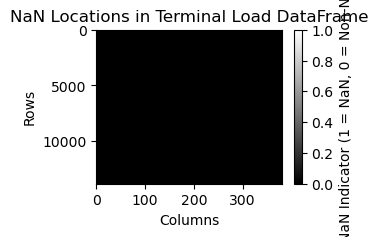

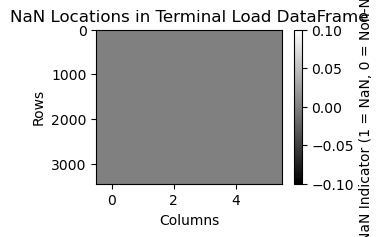

DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)

In [23]:
nan_viz(df)
nan_viz(weather)

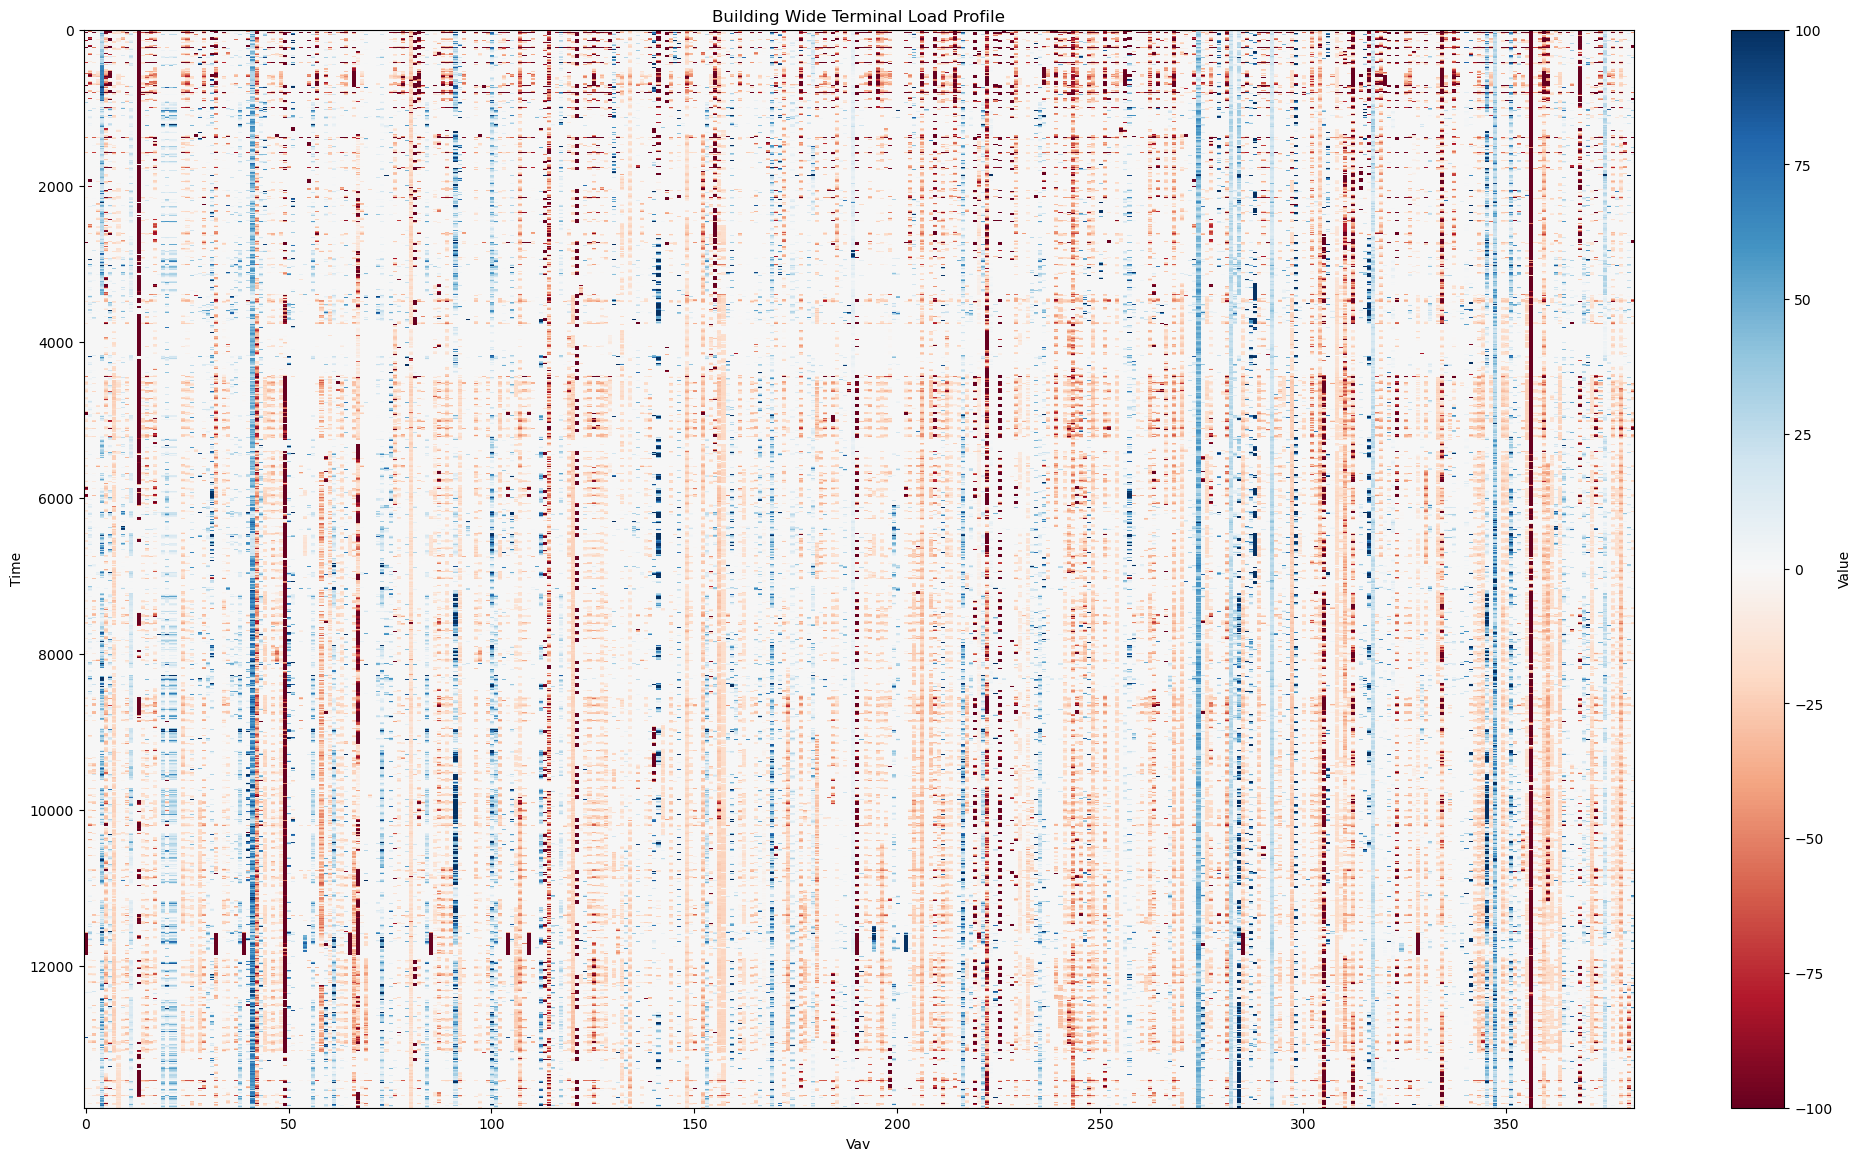

In [24]:
tload_viz(df)

We have time series for a given building, corresponding do each zone terminal load, a measure of how needy a zone i in term of cooling or reheat. 

We'll denote this:

$$T_{load}^{(z,t)}$$

With $t$ indexing the time and $z$ denoting the zone of the building. We have  382  zone in this building, which makes a vector of 
$$T_{load, building}^{t} \in \mathbb R ^{(382,1)}$$

We also have a input feature timeseries, which is common for all the building as well. This includes features such as Outside Air temperautre or solar irradiation. 

$$W^{t}$$

In the code the weather dataframe is formatted like so:
| Date                | temperature | RH  | Tdew | wind | sun_rad | daily_rain |
|---------------------|-------------|-----|------|------|---------|------------|
| 2023-05-01 00:00:00 | 52.6        | 75.0| 44.8 | 9.2  | 0.0     | 0.00       |
| 2023-05-01 01:00:00 | 52.4        | 75.0| 44.7 | 7.4  | 0.0     | 0.00       |
| 2023-05-01 02:00:00 | 52.2        | 75.0| 44.4 | 9.0  | 0.0     | 0.00       |

And the 

| Date                | VAV2-33 | VAV2-17   | VAV3-18 | VAV4-22    | VAV2-20 | VAV1-18 | VAV2-03   | VAV3-06 | VAV2-31 | VAV2-29 | ... | VAV2-11 | VAV2-32 | VAV4-25    | VAV4-08 | VAV1-02   | VAV0-00-4  | VAV0-04 | VAV1-12 | VAV2-18 | VAV3-15 |
|---------------------|---------|-----------|---------|------------|---------|---------|-----------|---------|---------|---------|-----|---------|---------|------------|---------|-----------|------------|---------|---------|---------|---------|
| 2023-05-01 00:00:00 | 0.0     | 0.000000  | 0.0     | -10.687083 | 0.0     | 0.0     | -5.494500 | 0.000000| 0.0     | -100.0  | ... | 0.0     | 0.0     | -16.662916 | 0.0     | -0.435333 | -8.518917  | 0.0     | 0.0     | 0.0     | 0.000000|
| 2023-05-01 01:00:00 | 0.0     | -0.355917 | 0.0     | -10.881667 | 0.0     | 0.0     | -7.798417 | 0.000000| 0.0     | -100.0  | ... | 0.0     | 0.0     | -16.492833 | 0.0     | -7.894917 | -7.576250  | 0.0     | 0.0     | 0.0     | 0.000000|
| 2023-05-01 02:00:00 | 0.0     | -0.559250 | 0.0     | -10.827083 | 0.0     | 0.0     | -6.123417 | 0.000000| 0.0     | -100.0  | ... | 0.0     | 0.0     | -16.670916 | 0.0     | -6.497750 | -8.176333  | 0.0     | 0.0     | 0.0     | -1.364750|

I want to train a LSTM architecture that will for an input of the past 2 weeks of data of terminal load vector, will try to predict the next week. I also have the exact weather for the two past weeks and the predicting wek (that could be a forcecast in real life use), to help the prediction of model, as those should be correlated in some ways. 

Give me a way to start formatting my code to have such a model, train it and test it. I want to have september has my validation set. 


# Quick look at the data

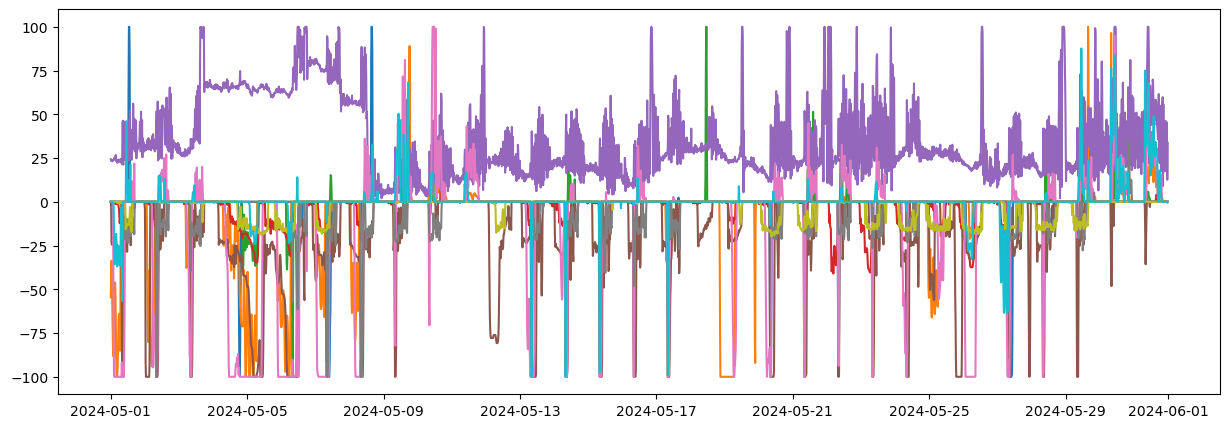

In [25]:
plt.figure(figsize=(15,5))
for col in df.columns[:10]:
    plt.plot(df.loc[df.index.month == 5,col], label=col)

# Hyperparameters choice

In [26]:
n_epochs = 400 

# Base model

In [32]:
# Make sure both dataframes have datetime indices
df.index = pd.to_datetime(df.index)
weather.index = pd.to_datetime(weather.index)

# Train the model
model, train_losses, val_losses, train_dataset, val_dataset, train_loader, val_loader = get_trained_model(df, weather, n_epochs=n_epochs)

Checking data availability...
Terminal loads date range: 2024-04-29 00:00:00 to 2024-09-19 23:45:00
Weather data date range: 2024-04-29 00:00:00 to 2024-09-19 23:00:00

Using split date: 2024-08-21 00:00:00

Checking data sizes:
Training set hours: 10944
Validation set hours: 2880
Minimum required hours: 216

Creating datasets...
Created 105 valid sequences
First sequence shapes:
Input loads: (168, 382)
Input weather: (168, 6)
Target loads: (48, 382)
Target weather: (48, 6)
Created 22 valid sequences
First sequence shapes:
Input loads: (168, 382)
Input weather: (168, 6)
Target loads: (48, 382)
Target weather: (48, 6)

Creating dataloaders...

Initializing model...

Starting training...
Training on device: mps
Number of training batches: 4
Number of validation batches: 1
torch.Size([32, 168, 382])
torch.Size([32, 168, 6])
torch.Size([32, 168, 382])
torch.Size([32, 168, 6])
torch.Size([32, 168, 382])
torch.Size([32, 168, 6])
torch.Size([9, 168, 382])
torch.Size([9, 168, 6])
torch.Size([2

KeyboardInterrupt: 

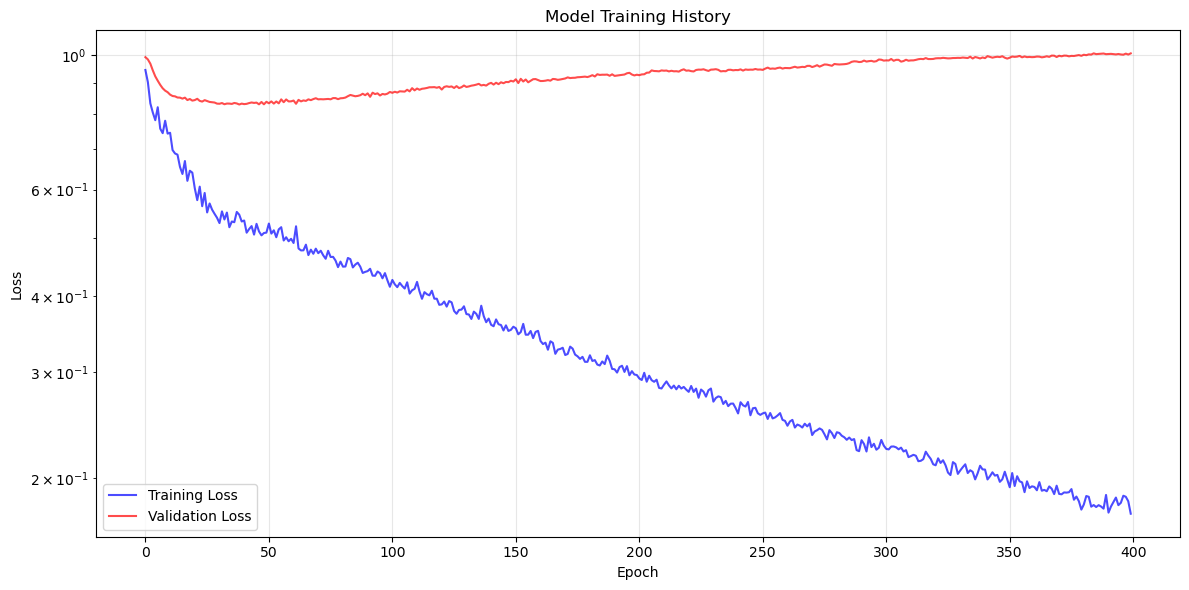

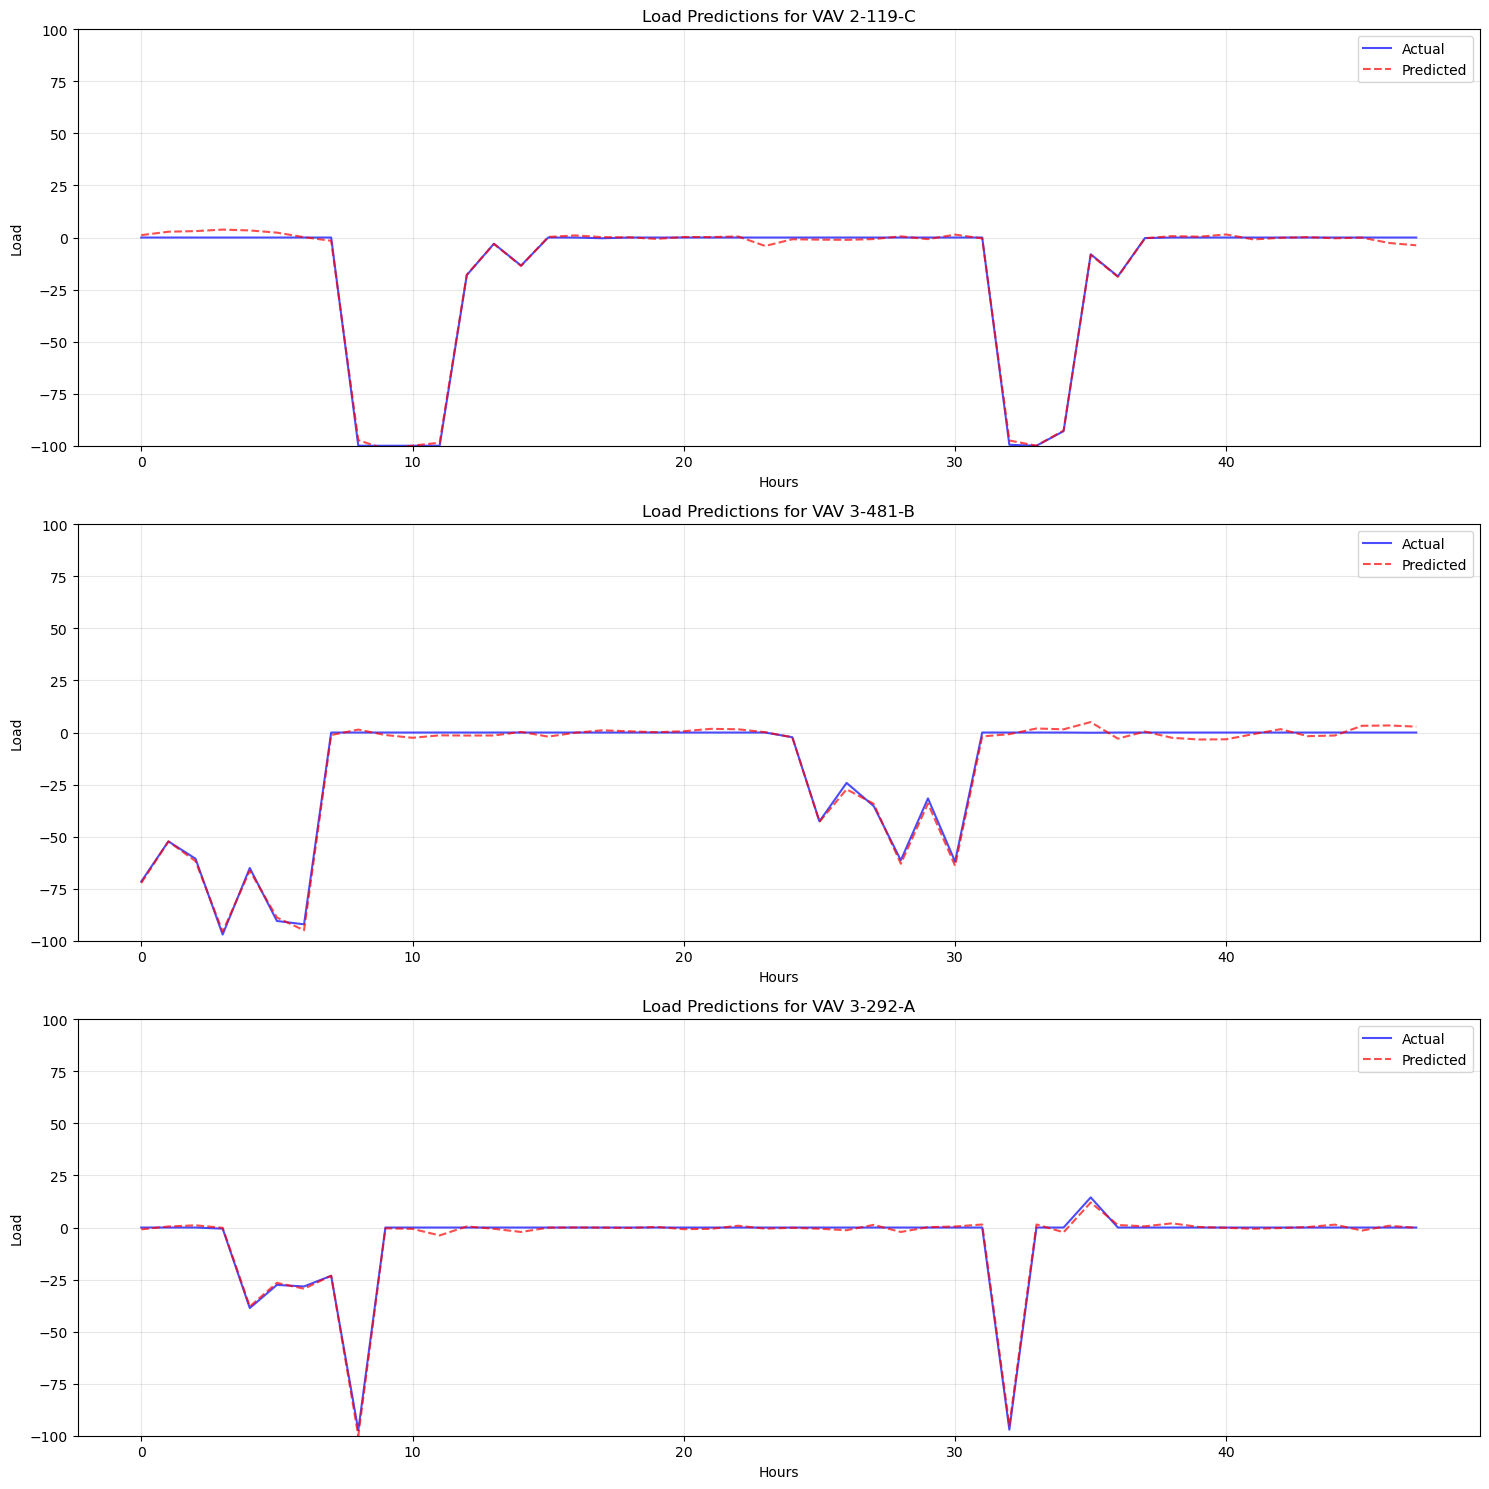

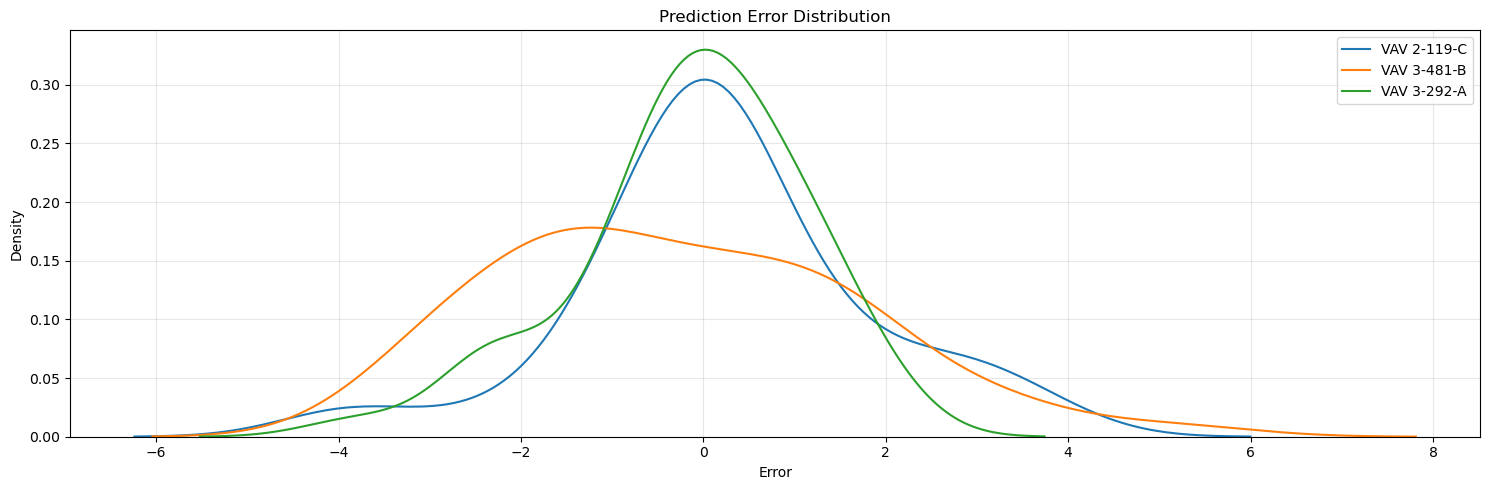


Prediction Metrics:
--------------------------------------------------

VAV 2-119-C:
MAPE: 10301258400.00%
RMSE: 1.58

VAV 3-481-B:
MAPE: 2671305600.00%
RMSE: 1.94

VAV 3-292-A:
MAPE: 1321422500.00%
RMSE: 1.24


In [28]:
# Correct way to call visualize_results
visualize_results(
    model=model,
    dataset=train_dataset,  # The dataset object
    load_scaler=train_dataset.load_scaler,  # The actual scaler object
    train_losses=train_losses,
    val_losses=val_losses,
    zones_names=df.columns,
    sample_idx=0,
)

# Dropout model

In [29]:
model_dropout, train_losses_dropout, val_losses_dropout, train_dataset_dropout, val_dataset_dropout, train_loader_dropout, val_loader_dropout = get_trained_model(df, weather, n_epochs=n_epochs, p_dropout=0.2)

Checking data availability...
Terminal loads date range: 2024-04-29 00:00:00 to 2024-09-19 23:45:00
Weather data date range: 2024-04-29 00:00:00 to 2024-09-19 23:00:00

Using split date: 2024-08-21 00:00:00

Checking data sizes:
Training set hours: 10944
Validation set hours: 2880
Minimum required hours: 216

Creating datasets...
Created 105 valid sequences
First sequence shapes:
Input loads: (168, 382)
Input weather: (168, 6)
Target loads: (48, 382)
Target weather: (48, 6)
Created 22 valid sequences
First sequence shapes:
Input loads: (168, 382)
Input weather: (168, 6)
Target loads: (48, 382)
Target weather: (48, 6)

Creating dataloaders...

Initializing model...

Starting training...
Training on device: mps
Number of training batches: 4
Number of validation batches: 1
Epoch [5/400], Train Loss: 0.8538, Val Loss: 0.9292
Epoch [10/400], Train Loss: 0.7318, Val Loss: 0.8731
Epoch [15/400], Train Loss: 0.6962, Val Loss: 0.8558
Epoch [20/400], Train Loss: 0.6800, Val Loss: 0.8446
Epoch [2

In [30]:
models = [model, model_dropout]
train_losses_all = [train_losses, train_losses_dropout]
val_losses_all = [val_losses, val_losses_dropout]
model_names = ['No Dropout', 'Dropout']

Model 1
--------------------------------------------------
TerminalLoadPredictor(
  (loads_lstm): LSTM(382, 64, num_layers=2, batch_first=True)
  (weather_lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=64, out_features=18336, bias=True)
  )
)


Model 2
--------------------------------------------------
TerminalLoadPredictor(
  (loads_lstm): LSTM(382, 64, num_layers=2, batch_first=True)
  (weather_lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=18336, bias=True)
  )
)




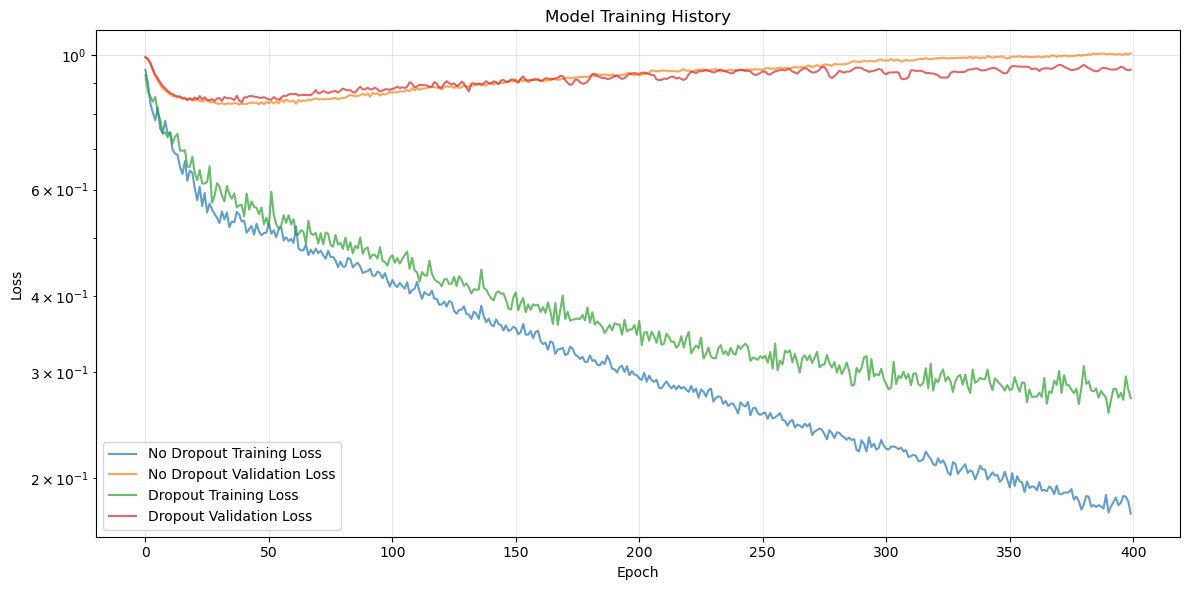

In [31]:
compare_results(
    models=models,
    train_losses=train_losses_all,
    val_losses=val_losses_all,
    model_names=model_names,
)